# Out-of-distribution detection tutorial

This notebook provides a tutorial for out-of-distribution detection using two methods: one using contrastive learning with neural networks, and another using decision trees for outlier detection. We use the same *P. falciparum* transcriptomics dataset described in [Zhang et al. iScience 2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8873607/), where each observation is the transcriptome of a *P. falciparum* isolate taken from a patient and its corresponding label is whether or not that isolate was resistant to artemisinin, an anti-malarial drug.

**Overview:** This notebook first splits a master data file into a training and validation set such that we have reason to believe that the observations in the validation set come from a slightly different distribution than the observations in the training dataset. For example, we can ensure that this is the case by choosing all observations collected from a particular country to be validation observations. Then, we perform OOD detection on this validation set, yielding validation observations that have each been labeled as either in-distribution (ID) or out-of-distribution (OOD). Finally, we evaluate the performance of a machine learning model (trained on the training set) on the ID validation observations and the OOD validation observations.

**Note:** The code below assumes that this notebook and all the code required to train the anti-malarial resistance classifier are all placed in the same folder (directory). As an example, here is our folder structure:

```
notebook/
|  common.py                                  |
|  main.py                                    |
|  models.py                                  |- (code for anti-malarial resistance ML algorithm)
|  preprocess.py                              |
|  statistics.py                              |
|  README.md                                     (info document)
|  requirements.txt                              (required packages)
|  SubCh2_TrainingData_imputed.csv               (master dataset)
|  tutorial.ipynb                                (this notebook)
```

In [1]:
import os
import shutil

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import sklearn.ensemble

import tqdm
import subprocess

In [2]:
# Set a seed for reproducibility
np.random.seed(256)
torch.manual_seed(256) # comment this line out if you don't want to set a seed!

In [3]:
# Define where inputs are loaded from

DATASET_PATH = "SubCh2_TrainingData_imputed.csv" # path to the master dataset

In [4]:
# Define where outputs are stored

TRAIN_PATH = "train.csv"
VAL_PATH = "val.csv"
VAL_LABELED_PATH = "val_labeled.csv"
VAL_ID_PATH = "val_id.csv"
VAL_OOD_PATH = "val_ood.csv"

## Dataset splitting

To ensure that the training and validation observations really do come from slightly different distributions, we'll subset the master dataset of *in vivo* transcriptomes into training and validation observations based on their country.

In [5]:
df = pd.read_csv(DATASET_PATH)

In [7]:
train = df.loc[df["Country"].isin(['Laos', 'Thailand', 'Vietnam', 'Cambodia']), :]
val = df.loc[df["Country"] == 'Myanmar', :]

print(f"Number of training observations: {len(train)}")
print(f"Number of validation observations: {len(val)}")

Number of training observations: 786
Number of validation observations: 82


In [8]:
train.to_csv(TRAIN_PATH, index=False)
val.to_csv(VAL_PATH, index=False)

## Out-of-distribution detection

We'll detect OOD observations in the validation dataset relative to the training distribution; in other words, we'll train our OOD detector on the training dataset and use it to predict which observations in the validation dataset are OOD. We implement two approaches:

- `DeepNN`: The deep nearest neighbors approach from [Sun et al. ICML 2022](https://arxiv.org/abs/2204.06507)
- `IsolationForest`: The isolation forest algorithm ([Liu et al. 2008](https://ieeexplore.ieee.org/document/4781136)), implemented by [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [12]:
class Feedforward(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        """
        Simple neural network to be used with the DeepNN OOD detector.
        """
        super(Feedforward, self).__init__()

        self.L1 = nn.Linear(in_features, 128)
        self.a1 = nn.ReLU()
        self.L2 = nn.Linear(128, 64)
        self.a2 = nn.ReLU()
        self.L3 = nn.Linear(64, 32)
        self.a3 = nn.ReLU()
        self.LP = nn.Linear(32, 16)
        self.aP = nn.ReLU()
        self.LF = nn.Linear(16, out_features)
    
    def forward(self, x, return_penultimate_preact: bool=False, return_penultimate_postact: bool=False):
        z = self.L1(x)
        z = self.a1(z)
        z = self.L2(z)
        z = self.a2(z)
        z = self.L3(z)
        z = self.a3(z)
        z = self.LP(z)
        if return_penultimate_preact: return z
        z = self.aP(z)
        if return_penultimate_postact: return z
        z = self.LF(z)
        return z

class DeepNN:
    def __init__(self, in_features, out_features, k=25, threshold=0.46):
        """
        A simple implementation of the Deep Nearest Neighbors algorithm (Sun et al. ICML 2022).
        The algorithm trains a neural network on the training dataset via contrastive learning.
        The learned embeddings of the training observations are then compared to the embeddings 
        of new observations to determine whether those new observations are OOD or not: if the 
        distance of the new embedding to its k-th nearest neighbor in the training embeddings is
        greater than the threshold, the new observation is labeled as OOD.
        
        The default values of the parameters are the values we used. However, we did not
        extensively tune these parameters, and it is certainly possible that another setting of these 
        parameters performs better on most validation datasets.

        Args:
            in_features: The input dimension for the neural network (set to the number of variables 
                per observation)
            out_features: The output dimension for the neural network (set to the number of training
                observations, for contrastive learning)
            k: The number of the nearest neighbor to compare against
            threshold: The maximum distance allowed between the new observation's embedding and its
                k-th nearest training embedding (distances greater than this are considered OOD)
        """
        self.net = Feedforward(in_features, out_features)
        self.optimizer = optim.Adam(self.net.parameters(), lr=1e-3)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.k = k
        self.threshold = threshold

    def train(self, data: pd.DataFrame, num_epochs=46, batch_size=64):
        """
        Trains the neural network and computes the training embeddings.

        Args:
            data: A dataframe with the same format as the master dataframe
            num_epochs: Number of epochs
            batch_size: Batch size
        """
        data = data.iloc[:, 4:-1]
        X = data.to_numpy()
        Y = np.arange(len(X))

        X = torch.tensor(X, requires_grad=False, dtype=torch.get_default_dtype())
        Y = torch.tensor(Y, requires_grad=False, dtype=torch.long)

        for epoch in tqdm.tqdm(range(num_epochs)):
            perm = torch.randperm(X.shape[0])

            X_epoch = X[perm, :]
            Y_epoch = Y[perm]

            num_batches = X_epoch.shape[0] // batch_size

            for batch in range(num_batches):
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
    
                X_batch = X_epoch[batch_start:batch_end, :]
                Y_batch = Y_epoch[batch_start:batch_end]
    
                self.optimizer.zero_grad()
    
                Y_hat = self.net(X_batch)
    
                loss = self.loss_fn(Y_hat, Y_batch)
                loss.backward()
    
                self.optimizer.step()

        with torch.no_grad():
            train_embeddings = self.net(X, return_penultimate_preact=True).numpy()
            train_embeddings = [train_embeddings[i, :] for i in range(np.shape(train_embeddings)[0])]
            train_embeddings = [e / np.linalg.norm(e) for e in train_embeddings]
            self.train_embeddings = train_embeddings
    
    def _is_ood(self, obs):
        with torch.no_grad():
            z_new = self.net(torch.tensor(obs, dtype=torch.get_default_dtype()), return_penultimate_preact=True).squeeze().numpy()
            z_new = z_new / np.linalg.norm(z_new)
        
        # Compute and rank norms
        norms = [np.linalg.norm(z_new - z) for z in self.train_embeddings]
        ranked = sorted(norms)
    
        # Test the k-th threshold
        return ranked[self.k] > self.threshold

    def predict(self, data: pd.DataFrame):
        """
        Predict which examples in a new dataframe are OOD.

        Args:
            data: A dataframe with the same format as the master dataframe

        Returns:
            A copy of the dataframe with a new 'ood' column whose value is 1
            if that observation is OOD and 0 otherwise.
        """
        df = data.copy()

        data = data.iloc[:, 4:-1].to_numpy()
        
        ood = list()
        for i in range(np.shape(data)[0]):
            ood.append(self._is_ood(data[i, :]))
        ood = [int(o) for o in ood]

        df["ood"] = ood

        return df

In [10]:
class IsolationForest:
    def __init__(self):
        """
        Isolation forest OOD classifier. This class is a wrapper around 
        scikit-learn's IsolationForest.
        """
        self.detector = sklearn.ensemble.IsolationForest(random_state =256)

    def train(self, data: pd.DataFrame):
        """
        Train the OOD detection method.

        Args:
            data: The training dataframe. Assumes that this dataframe has the same 
                format as the master dataframe.
        """
        data = data.iloc[:, 4:-1].to_numpy()
        self.detector.fit(data)

    def predict(self, data: pd.DataFrame):
        """
        Predict which examples in a dataframe are OOD (1) or ID (0).

        Args:
            data: A dataframe with the same format as the master dataframe.

        Returns:
            A copy of the dataframe with a new 'ood' column whose value is 1 
            if that observation is OOD and 0 otherwise.
        """
        # Pop off the last column
        df = data.copy()

        data = data.iloc[:, 4:-1].to_numpy()
        
        y = self.detector.predict(data)
        y = (y == -1).astype(np.float32)
        y = [int(l) for l in y]

        df["ood"] = y
        return df

Having defined our OOD classifiers, we can now train them to predict which validation observations are OOD.

In [59]:
train = pd.read_csv(TRAIN_PATH)
val = pd.read_csv(VAL_PATH)

# set random seed for reproducibility
all_ood = list()
for s in range(10):
    np.random.seed(s)
    torch.manual_seed(s)

    ood_detector = DeepNN(train.iloc[:, 4:-1].shape[1], train.shape[0], k=30, threshold=0.38)
    #ood_detector = IsolationForest() # uncomment this line to use isolation forest instead

    ood_detector.train(train)

    val_labeled = ood_detector.predict(val)

    val_id = val_labeled.loc[val_labeled["ood"] == 0, :]
    val_id = val_id.iloc[:, :-1]

    val_ood = val_labeled.loc[val_labeled["ood"] == 1, :]
    val_ood = val_ood.iloc[:, :-1]

    all_ood.append(val_ood.Sample_Names.to_list())

# ood is the intersection of all the OOD predictions
ood_ = all_ood[0]
for i in range(1, len(all_ood)):
    ood_ = list(set(ood_).intersection(all_ood[i]))

val_id = val.loc[~val.Sample_Names.isin(ood_), :]
val_ood = val.loc[val.Sample_Names.isin(ood_), :]

print(f"Number of ID observations: {len(val_id)}")
print(f"Number of OOD observations: {len(val_ood)}")

100%|██████████| 46/46 [00:05<00:00,  7.94it/s]


Number of ID observations: 77
Number of OOD observations: 5


In [60]:
val_ood

,Sample_Names,Country,Asexual.stage..hpi.,Kmeans.Grp,PF3D7_0100100,PF3D7_0100200,PF3D7_0100300,PF3D7_0100600,PF3D7_0100800,PF3D7_0101300,...,PF3D7_1478800,PF3D7_1479000,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,ClearanceRate_binary
26,GSM1428061,Myanmar,46,C,-0.145248,-0.957407,-2.217375,-0.268693,0.071866,0.088911,...,0.530842,0.948546,1.334291,0.317705,-0.157572,0.436781,-0.473657,-1.266207,-1.311112,0
33,GSM1428068,Myanmar,4,C,0.377525,-0.955513,-1.880228,0.154637,0.258779,-0.001010,...,-0.289824,0.965047,-0.279265,-0.320927,0.041377,-1.425591,0.064533,-1.792388,-1.885604,0
44,GSM1428079,Myanmar,14,C,1.348996,-0.893770,-1.243182,-2.018616,0.158581,0.053446,...,-0.934099,-0.118217,0.356660,-1.316970,-0.128464,0.157024,1.759223,-0.621029,-0.968813,0
52,GSM1428087,Myanmar,8,C,1.132429,-0.216859,-1.763500,-2.086270,-0.041601,0.074811,...,0.074811,1.187649,0.074811,-0.057291,0.074811,-1.264495,1.509683,-1.032050,-0.646892,0
76,GSM1428111,Myanmar,4,C,0.420027,-1.016241,-1.792388,-0.432610,-0.395171,-0.273703,...,-0.424715,0.323596,0.952135,0.362312,-0.145643,-0.918961,0.333272,-1.330322,-0.953608,1


In [55]:
val_labeled.to_csv(VAL_LABELED_PATH)
val_id.to_csv(VAL_ID_PATH)
val_ood.to_csv(VAL_OOD_PATH)

## Training the machine learning algorithm

Now that we have an OOD detector, we can train any machine learning algorithm on the training dataset and then evaluate its performance on both the ID and OOD unseen (validation) observations. Here, we'll use the winning algorithm ([Zhang et al. iScience 2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8873607/)) from the [DREAM Malaria Challenge](https://www.synapse.org/Synapse:syn16924919/wiki/583955).

In [63]:
#if os.path.exists("val"):
#    raise Exception(f"Error: val_id already exists. Please delete this directory.")
#    shutil.rmtree("val") # uncomment this line to automatically delete the existing directory (and comment the line above)

#os.makedirs("val", exist_ok=True)
subprocess.run(["python", "main.py", 
                f"--train_path={TRAIN_PATH}", 
                f"--valid_path1={VAL_PATH}", 
                f"--valid_path2={VAL_ID_PATH}",
                f"--valid_path3={VAL_OOD_PATH}",
                "--validate_in_vivo", 
                "--no_quantile"]
               )
#shutil.move("invitro", "val/invitro")
#shutil.move("invivo", "val/invivo")
#shutil.move("params", "val/params")
#shutil.move("performance", "val/performance")

CompletedProcess(args=['python', 'main.py', '--train_path=train.csv', '--valid_path1=val.csv', '--valid_path2=val_id.csv', '--valid_path3=val_ood.csv', '--validate_in_vivo', '--no_quantile'], returncode=0)

## Evaluating the performance of the algorithm

Finally, we can parse the output of the training process to determine the performance of the machine learning model on the ID and OOD validation observations.

In [65]:
val_results = pd.read_csv("performance/in_vitro1_tv_results.csv")
val_id_results = pd.read_csv("performance/in_vitro2_tv_results.csv")
val_ood_results = pd.read_csv("performance/in_vitro3_tv_results.csv")

acc = val_results["accuracy"].mean()
acc_id = val_id_results["accuracy"].mean()
acc_ood = val_ood_results["accuracy"].mean()

print(f"Accuracy on all validation observations: {acc}")
print(f"Accuracy on in-distribution validation observations: {acc_id}")
print(f"Accuracy on out-of-distribution validation observations: {acc_ood}")

acc = val_results["AUROC"].mean()
acc_id = val_id_results["AUROC"].mean()
acc_ood = val_ood_results["AUROC"].mean()

print(f"AUROC on all validation observations: {acc}")
print(f"AUROC on in-distribution validation observations: {acc_id}")
print(f"AUROC on out-of-distribution validation observations: {acc_ood}")

Accuracy on all validation observations: 0.6577322880371661
Accuracy on in-distribution validation observations: 0.6794021164021163
Accuracy on out-of-distribution validation observations: 0.42555555555555546
AUROC on all validation observations: 0.5998719590268886
AUROC on in-distribution validation observations: 0.6956228956228955
AUROC on out-of-distribution validation observations: 0.32999999999999996


In [82]:
val_results = pd.read_csv("performance/in_vitro1_tv_confidence.csv")
val_id_results = pd.read_csv("performance/in_vitro2_tv_confidence.csv")
val_ood_results = pd.read_csv("performance/in_vitro3_tv_confidence.csv")


In [83]:
val_results['Data'] = 'all'
val_id_results['Data'] = 'In-distribution'
val_ood_results['Data'] = 'Out-of-distribution'
all_results = pd.concat([val_results, val_id_results, val_ood_results])
all_results

,data,Pearsonr mean[95CI],Spearmanr mean[95CI],C-index mean[95CI],accuracy,AUROC mean[95CI],AUPRC mean[95CI],Data
0,na_na,"0.1174[0.0563, 0.1818]","0.1148[0.0572, 0.1842]","0.0000[0.0000, 0.0000]","0.6577[0.6577, 0.6577]","0.5973[0.5508, 0.6605]","0.2222[0.1668, 0.2859]",all
0,na_na,"0.2309[0.1562, 0.3078]","0.2177[0.1450, 0.2954]","0.0000[0.0000, 0.0000]","0.6794[0.6794, 0.6794]","0.6934[0.6356, 0.7593]","0.2679[0.1844, 0.3792]",In-distribution
0,na_na,"-0.3165[-0.4643, -0.1653]","-0.2645[-0.4366, -0.0842]","0.0000[0.0000, 0.0000]","0.4256[0.4256, 0.4256]","0.3310[0.2153, 0.4421]","0.2071[0.1319, 0.2976]",Out-of-distribution


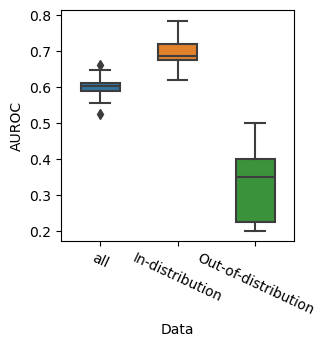

In [79]:
# make plot: box plot of confidence scores for ID and OOD observations

import matplotlib.pyplot as plt
import seaborn as sns

val_results['Data'] = 'all'
val_id_results['Data'] = 'In-distribution'
val_ood_results['Data'] = 'Out-of-distribution'
all_results = pd.concat([val_results, val_id_results, val_ood_results])

# plot AUROC
plt.figure(figsize=(3, 3))
sns.boxplot(x='Data', y='AUROC', data=all_results, width=0.5)
plt.ylabel('AUROC')
# the xlabel is too long, so we will rotate it
plt.xticks(rotation=335)
# save as pdf
plt.savefig('auroc.pdf', bbox_inches='tight')

